In [1]:
import pickle
import matplotlib.pyplot as plt
from hts import HTSRegressor
from hts.hierarchy import HierarchyTree
from m5 import *
import time


import warnings
warnings.filterwarnings("ignore")

## Auxiliar Function

In [2]:
# Function to reduce memory to increase performance to decrease run time.
def downcasting(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [3]:
def runModel(modelName, hierarchy, dataFrame, revisionMethod=None):
    
    clf = HTSRegressor(model=modelName, revision_method=revisionMethod, n_jobs=4)
    return clf.fit(dataFrame, hierarchy)

In [4]:
def prediction(model, steps=28):
    return model.predict(steps_ahead=steps)

In [5]:
def saveModel(path, model, method, ols, samples=None):
    
    dt = time.localtime()
    strinstante = "%02d-%02d-%04d-%02d-%02d-%02d" % (
    dt.tm_year, dt.tm_mon, dt.tm_mday, dt.tm_hour, dt.tm_min, dt.tm_sec)

    if (samples):
        filename = path + "model" + method + ols + str(samples) + strinstante + ".pkl"
    else:
        filename = path + "model" + method + ols + strinstante + ".pkl"
        
    with open(filename, 'wb') as file:
        pickle.dump(model, file, protocol=4)

In [6]:
def loadModel(path):
        
    with open(path, 'rb') as file:
        model = pickle.load(file)
        
    return model

In [7]:
def saveDataset(path, dataFrame, method, ols, samples=None):
    
    dt = time.localtime()
    strinstante = "%02d-%02d-%04d-%02d-%02d-%02d" % (
    dt.tm_year, dt.tm_mon, dt.tm_mday, dt.tm_hour, dt.tm_min, dt.tm_sec)

    if (samples):
        filename = path + "dataset" + method + ols + str(samples) + strinstante + ".pkl"
    else:
        filename = path + "dataset" + method + ols + strinstante + ".pkl"
        
    dataFrame.to_pickle(filename)

In [8]:
def plot(dictPlot, predictions, dataFrame):
    
    fig, axs = plt.subplots(len(dictPlot), figsize=(20, 30), sharex=True)
    # ax.grid(alpha=0.75)
    PLOT_FROM = 0
    dts = predictions[PLOT_FROM:].index

    for i, group in enumerate(dictPlot):
        axs[i].plot(dataFrame[PLOT_FROM:][group], 
                lw=1.1, 
                color='#2ecc71', 
                alpha=0.8, 
                label='Truth')
        axs[i].plot(predictions[PLOT_FROM:][group], 
                lw=1.1,
                color='#e74c3c', 
                alpha=0.8, 
                label='Prediction')
        axs[i].grid(alpha=0.75)
        axs[i].legend()
        axs[i].set_title(group)

In [9]:
def dataRangeSelection(df, start_date, end_date):
    #start_date = '2012-04-24'
    #end_date = '2016-04-24'
    mask = (df.index >= start_date) & (df.index <= end_date)    
    return df.loc[mask]

## create Hierarchy Tree Front

In [10]:
def createHierarchyTree(self, _last=True):

    ht_tree = {
            'name':  self.key,
        }
    child_count = len(self.children)
    
    for i, child in enumerate(self.children):
        _last = i == (child_count - 1)
        if i == 0:
            ht_tree['children'] = []
            
        ht_tree['children'].append(createHierarchyTree(child, _last=_last))
    return ht_tree

## Run

In [11]:
dataset_path = 'data/'
data_set = M5(dataset_path, samples=50)

data_set.train_set

,CA,WI,TX,CA_4,WI_2,WI_3,TX_2,CA_1,TX_3,TX_1,...,TX_3_FOODS_2_055_TX_3_validation,CA_4_HOUSEHOLD_1_524_CA_4_validation,CA_1_HOBBIES_1_328_CA_1_validation,CA_1_HOBBIES_1_295_CA_1_validation,CA_4_HOBBIES_2_095_CA_4_validation,TX_3_HOBBIES_1_213_TX_3_validation,TX_1_HOBBIES_1_089_TX_1_validation,CA_2_HOBBIES_1_177_CA_2_validation,CA_3_FOODS_1_016_CA_3_validation,total
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,31,12,9,0,0,6,3,10,2,4,...,0,0,2,0,0,2,0,0,3,52
2011-01-30,72,3,25,0,0,1,14,40,2,9,...,0,0,0,36,0,0,0,0,0,100
2011-01-31,59,8,11,0,0,8,9,39,0,2,...,0,0,1,36,0,0,0,0,0,78
2011-02-01,8,7,16,0,1,4,6,3,0,10,...,0,0,1,0,0,0,0,0,0,31
2011-02-02,24,5,11,0,0,5,2,9,1,8,...,0,0,0,8,0,1,0,0,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-20,18,13,9,1,0,6,6,5,0,3,...,0,0,1,0,0,0,0,1,0,40
2016-04-21,22,19,18,5,0,9,9,11,2,7,...,0,0,0,7,0,0,1,0,0,59
2016-04-22,23,12,10,2,0,4,4,7,4,2,...,0,1,0,4,0,0,1,1,0,45


## Preprocess Data (Optional)

In [12]:
dfSelected = downcasting(data_set.train_set)

## Json Tree Front

In [13]:
ht = HierarchyTree.from_nodes(nodes=data_set.hierarchy, df=dfSelected)
ht_tree = createHierarchyTree(ht)

ht_tree

{'name': 'total',
 'children': [{'name': 'CA',
   'children': [{'name': 'CA_4',
     'children': [{'name': 'CA_4_FOODS',
       'children': [{'name': 'CA_4_FOODS_3',
         'children': [{'name': 'CA_4_FOODS_3_143_CA_4_validation'}]},
        {'name': 'CA_4_FOODS_2',
         'children': [{'name': 'CA_4_FOODS_2_185_CA_4_validation'}]}]},
      {'name': 'CA_4_HOBBIES',
       'children': [{'name': 'CA_4_HOBBIES_1',
         'children': [{'name': 'CA_4_HOBBIES_1_042_CA_4_validation'},
          {'name': 'CA_4_HOBBIES_1_241_CA_4_validation'}]},
        {'name': 'CA_4_HOBBIES_2',
         'children': [{'name': 'CA_4_HOBBIES_2_076_CA_4_validation'},
          {'name': 'CA_4_HOBBIES_2_095_CA_4_validation'}]}]},
      {'name': 'CA_4_HOUSEHOLD',
       'children': [{'name': 'CA_4_HOUSEHOLD_2',
         'children': [{'name': 'CA_4_HOUSEHOLD_2_412_CA_4_validation'}]},
        {'name': 'CA_4_HOUSEHOLD_1',
         'children': [{'name': 'CA_4_HOUSEHOLD_1_524_CA_4_validation'}]}]}]},
    {'name': 

In [14]:
model = runModel('sarimax', data_set.hierarchy, dfSelected, revisionMethod='OLS')

Fitting models: 100%|██████████| 18/18 [00:01<00:00, 10.13it/s]


## Prediction 

In [15]:
preds = prediction(model, steps=28)

Fitting models: 100%|██████████| 18/18 [00:00<00:00, 24.60it/s]


In [16]:
preds

,total,CA,WI,TX,CA_4,CA_1,CA_3,CA_2,WI_2,WI_3,...,TX_3_FOODS_2_055_TX_3_validation,TX_3_HOUSEHOLD_1_529_TX_3_validation,TX_3_HOUSEHOLD_1_347_TX_3_validation,TX_3_HOUSEHOLD_2_391_TX_3_validation,TX_3_HOUSEHOLD_2_249_TX_3_validation,TX_3_HOBBIES_1_213_TX_3_validation,TX_1_FOODS_3_059_TX_1_validation,TX_1_FOODS_1_209_TX_1_validation,TX_1_FOODS_1_210_TX_1_validation,TX_1_HOBBIES_1_089_TX_1_validation
2011-01-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-30,30.469336,7.008061,3.596077,2.459389,-0.370493,4.110270,3.759571,-0.900254,1.372708,1.020165,...,-0.450127,2.389310,-1.019049,2.389310,-0.668350,-0.370493,2.459389,1.138043,-0.001354,7.378554
2011-01-31,58.868276,17.844413,3.170212,6.293790,-0.668884,12.107836,3.914074,-2.170986,3.749578,0.499336,...,-1.085493,4.130942,-4.510463,4.293595,3.683300,-0.668884,6.293790,-1.181990,-1.941588,18.513297
2011-02-01,45.162388,14.914287,1.436446,2.868472,-0.154069,11.605674,3.176880,-1.457187,2.146172,1.681198,...,-0.728594,4.336345,-5.495811,4.336345,2.932983,-0.154069,2.868472,-0.716013,-0.716013,15.068356
2011-02-02,19.782542,1.223121,5.998679,6.430830,-1.242563,1.021395,-0.725410,-1.835050,1.322767,0.656574,...,-0.917525,0.028446,-0.782303,0.028446,0.964503,-1.242563,6.430830,0.163723,-0.595874,2.465684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-18,2.855881,0.138386,0.171819,0.250597,-0.170593,-0.061108,-0.075246,0.053038,0.152831,-0.047214,...,0.026519,-0.125049,0.174853,-0.125049,0.188990,-0.170593,0.250597,-0.039389,-0.039389,0.308978
2016-05-19,2.575554,0.121711,0.151623,0.222930,-0.154731,-0.056104,-0.066064,0.049414,0.137584,-0.041637,...,0.024707,-0.113112,0.160160,-0.113112,0.170120,-0.154731,0.222930,-0.035654,-0.035654,0.276442
2016-05-20,2.322873,0.107337,0.133960,0.198386,-0.140244,-0.051403,-0.058092,0.045915,0.123861,-0.036800,...,0.022957,-0.102283,0.146474,-0.102283,0.153163,-0.140244,0.198386,-0.032213,-0.032213,0.247581
2016-05-21,2.095084,0.094899,0.118489,0.176600,-0.127033,-0.047014,-0.051155,0.042563,0.111509,-0.032594,...,0.021282,-0.092467,0.133778,-0.092467,0.137920,-0.127033,0.176600,-0.029056,-0.029056,0.221932


## Predicions Keys

In [17]:
preds.columns

Index(['total', 'CA', 'WI', 'TX', 'CA_4', 'CA_1', 'CA_3', 'CA_2', 'WI_2',
       'WI_3',
       ...
       'TX_3_FOODS_2_055_TX_3_validation',
       'TX_3_HOUSEHOLD_1_529_TX_3_validation',
       'TX_3_HOUSEHOLD_1_347_TX_3_validation',
       'TX_3_HOUSEHOLD_2_391_TX_3_validation',
       'TX_3_HOUSEHOLD_2_249_TX_3_validation',
       'TX_3_HOBBIES_1_213_TX_3_validation',
       'TX_1_FOODS_3_059_TX_1_validation', 'TX_1_FOODS_1_209_TX_1_validation',
       'TX_1_FOODS_1_210_TX_1_validation',
       'TX_1_HOBBIES_1_089_TX_1_validation'],
      dtype='object', length=124)

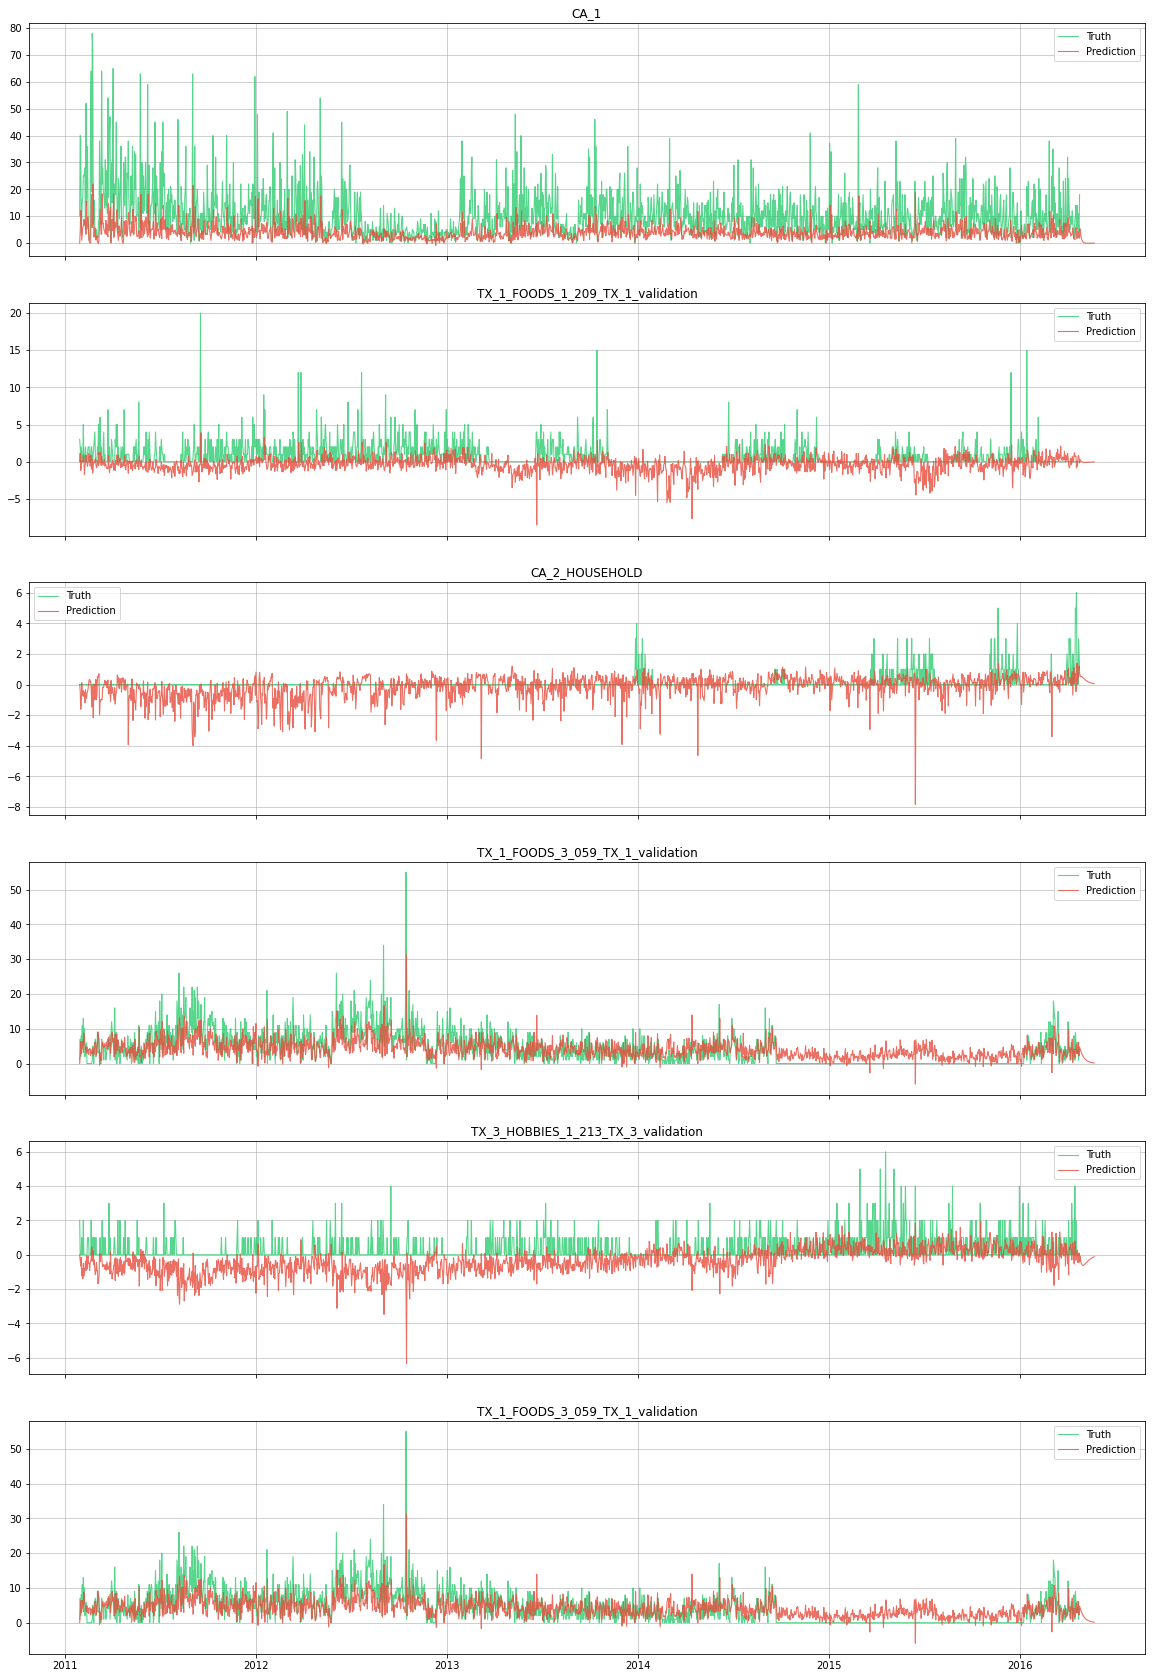

In [18]:
keys = [ 
        'CA_1',
        'TX_1_FOODS_1_209_TX_1_validation', 
        'CA_2_HOUSEHOLD',
        'TX_1_FOODS_3_059_TX_1_validation', 
        'TX_3_HOBBIES_1_213_TX_3_validation',
        'TX_1_FOODS_3_059_TX_1_validation',
       ]

plot(keys, preds, dfSelected)

# Saves 

In [19]:
path = 'result/'
method = '_sarimax'
ols = '_OLS_'
dataFrame = data_set.train_set
samples = data_set.sampleSize

saveDataset(path, dataFrame, method, ols, samples=samples)
saveModel(path, model, method, ols, samples=samples)

## Restore model

In [20]:
pathModel = 'result/model_sarimax_OLS_502021-12-0006-10-36-33.pkl'
modelRestore = loadModel(pathModel)